This project explanes how to construct yield curve from actual bond data. And how to construct spot curve using bootstrapping and interpolate technique. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from scipy.optimize import fsolve
from numpy import linalg as la
import scipy as sp
from scipy.interpolate import interp1d
bonds = pd.read_csv(r'C:\Users\Trevor\OneDrive\Desktop\q2data.csv').values.transpose()
coupon = [1.5, 1.5, 0.25, 0.25, 1.5, 2.25, 1.5, 1.25, 0.5, 0.25]
ttm = [6, 12, 18, 24, 28, 37, 43, 49, 55, 61]
bonds

In [36]:
bonds_dirty = []
for i in range(1,6):
    sub = []
    j = 0
    b = bonds[i-1]
    while j != 10:
        if ttm[j] % 6 == 0:
            d = b[j] + coupon[j]*(1/2 - (12+i)/365)
        else: 
            ai = (((j+1)*6 - ttm[j])/12 - (12+i)/365)*coupon[j]
            d = b[j] + ai
        sub.append(round(d,3))
        j += 1
    bonds_dirty.append(sub)
for i in range(1,6):
    sub = []
    j = 0
    b = bonds[i+4]
    while j != 10:
        if ttm[j] % 6 == 0:
            d = b[j] + coupon[j]*(1/2 - (6-i)/365)
        else: 
            ai = (((j+1)*6 - ttm[j])/12 - (6-i)/365)*coupon[j]
            d =b[j] + ai
        sub.append(round(d,3))
        j += 1
    bonds_dirty.append(sub)
bd = np.transpose(bonds_dirty)

Calculatating yield

In [39]:
normal = []
for i in range(4):
    sub = []
    for p in bd[i]:
        cp = coupon[i]/2
        func = lambda r: p - sum(np.array([(cp)/((1+(r/2))**(m)) for m in range(0,i+2)])) - (100)/((1+(r/2))**(i+1))
        ytm = (optimize.newton(func, 0.0005))
        sub.append(ytm)
    normal.append(sub) 

i = 4
sub = []
for p in bd[i]:
    cp = coupon[i]/2
    diff = ttm[i]/6 - i
    func = lambda r: p - sum(np.array([(cp)/((1+(r/2))**(m+diff)) for m in range(0,i+1)])) - (100)/((1+(r/2))**(i+1))
    ytm = (optimize.newton(func, 0.0005))
    sub.append(ytm)
normal.append(sub)
for i in range(5, 10):
    sub = []
    for p in bd[i]:
        cp = coupon[i]/2
        diff = ttm[i]/6 - (i + 1) 
        func = lambda r: p - sum(np.array([(cp)/((1+(r/2))**(m+diff)) for m in range(0,i+1)]))-(100)/((1+(r/2))**(ttm[i]/6))
        ytm = (optimize.newton(func, 0.0005))
        sub.append(ytm)
    normal.append(sub)
knormal = np.transpose(normal)
knormal
#np.savetxt('q4adata.csv', np.array(y), delimiter=',')

array([[0.00085396, 0.00111837, 0.00122511, 0.00189357, 0.00166294,
        0.00255779, 0.00317874, 0.00374183, 0.00432102, 0.00495778],
       [0.00115203, 0.00116789, 0.00129844, 0.00194866, 0.00164324,
        0.00257687, 0.00316492, 0.00374914, 0.00434752, 0.00497789],
       [0.00162912, 0.00150478, 0.0014985 , 0.00204885, 0.00181668,
        0.0027232 , 0.00325887, 0.00378325, 0.00439388, 0.00500001],
       [0.00190752, 0.00164355, 0.00150517, 0.00205386, 0.00187188,
        0.00280594, 0.00343581, 0.00398559, 0.00457505, 0.00520326],
       [0.00198708, 0.00168321, 0.00151184, 0.00205887, 0.00188766,
        0.00276138, 0.00330862, 0.00391975, 0.00446677, 0.00510261],
       [0.00121165, 0.00139577, 0.00158522, 0.00211398, 0.0018916 ,
        0.00268502, 0.00303511, 0.00362492, 0.00421068, 0.00482512],
       [0.00111228, 0.00134623, 0.00151851, 0.00206388, 0.00179302,
        0.00247512, 0.00310415, 0.00369067, 0.00429454, 0.00484522],
       [0.00103279, 0.00120752, 0.0013784

Interpolate yield (semi annual discrete compound)

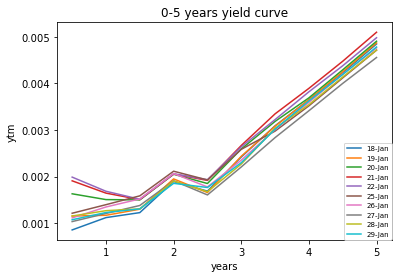

In [117]:
x = []
for k in ttm:
    x.append(k/12)
adjusted_ytm = []
for y in knormal:
    new_x = np.linspace(0.5, 5, 10)
    new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)
    adjusted_ytm.append(new_y)
date = ['18-Jan', '19-Jan', '20-Jan', '21-Jan', '22-Jan', '25-Jan', '26-Jan', '27-Jan', '28-Jan', '29-Jan']
time = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
i = 0
fig = plt.title('0-5 years yield curve')
for a in adjusted_ytm:
    plt.plot(time,a, label = date[i])
    i+= 1
plt.ylabel('ytm')
plt.xlabel('years')
plt.legend(loc='lower right', borderaxespad=0., fontsize = 7)
#plt.savefig("q4aytm.png")

Calculating spot rate, there are three cases.

In [122]:
spot = []
spot.append(normal[0])
for i in range(1, 4):
    sub = []
    cp = coupon[i]
    for j in range(10):
        p = bd[i][j]
        func = lambda r:sum(np.array([(cp)/(1+(spot[m][j]/2)**(m+1)) for m in range(i)])) + (100+cp)/((1+(r/2))**(i+1)) - p
        s = (optimize.newton(func, 0.0005))
        sub.append(s)
    spot.append(sub)

i = 4 #case where the maturity is not a multiple of 6 months
sub = []
cp = coupon[i]
diff = ttm[i]/6 - i
for j in range(10):
    x = [ttm[k]/6 for k in range(i)]
    x.insert(0,0)
    y = [spot[m][j] for m in range(i)]
    y.insert(0,0)
    new_x = np.linspace(diff, 3+diff, i)
    new_y = np.interp(new_x, x, y)
    p = bd[i][j]
    func = lambda r:sum(np.array([(cp)/(1+(new_y[m]/2)**(m+diff)) for m in range(i)])) \
    + (100+cp)/((1+(r/2))**(ttm[i]/6)) - p
    s = (optimize.newton(func, 0.0005))
    sub.append(s)
spot.append(sub)

i = 5 #case where maturity is 37 month from now, need to interpolate the missing rate
sub = []
cp = coupon[i]
diff = ttm[i]/6 - (i+1)
for j in range(10):
    x = [ttm[k]/6 for k in range(i)]
    x.insert(0,0)
    y = [spot[m][j] for m in range(i)]
    y.insert(0,0)
    new_x = np.linspace(diff, 4+diff, i)
    new_y = np.interp(new_x, x, y)
    p = bd[i][j]
    func = lambda r: sum(np.array([(cp)/(1+(new_y[m]/2)**(m+diff)) for m in range(i)]))+ cp/((1+(new_y[-1]+(0.5*(r-new_y[-1])))/2)**(5+diff)) + (100+cp)/((1+(r/2))**(ttm[i]/6)) - p
    s = (optimize.newton(func, 0.0005))
    sub.append(s)
spot.append(sub)

for i in range(6, 10): #same cases as i = 4
    sub = []
    cp = coupon[i]
    diff = ttm[i]/6 - (i+1)
    for j in range(10):
        x = [ttm[k]/6 for k in range(i)]
        x.insert(0,0)
        y = [spot[m][j] for m in range(i)]
        y.insert(0,0)
        new_x = np.linspace(diff, ttm[i]/6 - 1, i+1)
        new_y = np.interp(new_x, x, y)
        p = bd[i][j]
        func = lambda r:sum(np.array([(cp)/(1+(new_y[m]/2)**(m+diff)) for m in range(i+1)])) + (100+cp)/((1+(r/2))**(ttm[i]/6)) - p
        s = (optimize.newton(func, 0.0005))
        sub.append(s)
    spot.append(sub)
spot = np.transpose(spot)
spot

array([[0.00085396, 0.00855068, 0.00289373, 0.00377782, 0.01804448,
        0.03123075, 0.02199953, 0.01916661, 0.0103496 , 0.00793925],
       [0.00115203, 0.00859835, 0.00296706, 0.00383302, 0.01801595,
        0.0311948 , 0.02195214, 0.01915085, 0.01036885, 0.00795608],
       [0.00162912, 0.00893418, 0.00316739, 0.00393344, 0.01820238,
        0.03128694, 0.02201543, 0.01915932, 0.01040703, 0.00797422],
       [0.00190752, 0.0090719 , 0.00317385, 0.0039383 , 0.01825973,
        0.0313461 , 0.02218967, 0.01936517, 0.01059015, 0.00817946],
       [0.00198708, 0.00911126, 0.00318047, 0.00394328, 0.01827617,
        0.0312885 , 0.02204653, 0.01929034, 0.01047672, 0.00807626],
       [0.00121165, 0.00882748, 0.00325475, 0.00399918, 0.01829472,
        0.03130248, 0.02180531, 0.01901218, 0.01022561, 0.00779962],
       [0.00111228, 0.00877831, 0.0031879 , 0.00394887, 0.01818559,
        0.03108796, 0.02188984, 0.01909031, 0.01031491, 0.00782119],
       [0.00103279, 0.00863916, 0.0030474

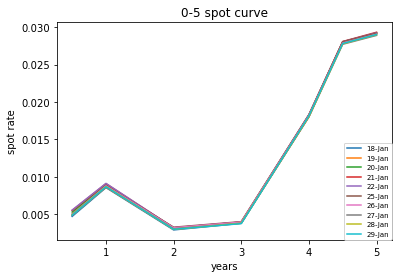

In [124]:
adjusted_spot = []
for y in spot: #spline interpolate
    new_x = np.linspace(0.5, 5, 10)
    new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)
    adjusted_spot.append(new_y)
fig2 = plt.title('0-5 spot curve')
i = 0
for a in adjusted_spot:
    plt.plot(time,a, label = date[i])
    i+= 1
plt.ylabel('spot rate')
plt.xlabel('years')
plt.legend(loc='lower right', borderaxespad=0., fontsize = 7)
#plt.savefig('q4b_f.png')

Calculate 1 year forward rate from year 2 to year 5

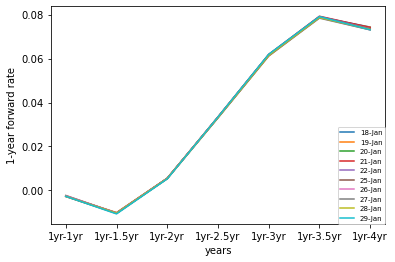

In [143]:
forward = []
for i in adjusted_spot:
    sub = []
    for j in range(1,5):
        func = lambda f : (1+i[2*j+1]/2)**(2*(j+1)) - ((1+i[2*j-1]/2)**(2*(j)))*((1+f/2)**(2))
        sub.append(optimize.newton(func, 0.0005))
    forward.append(sub)

f_time = ['1yr-1yr','1yr-1.5yr','1yr-2yr','1yr-2.5yr','1yr-3yr','1yr-3.5yr','1yr-4yr']
#fig3 = plt.title('2-5 forward curve')
i = 0
adjusted_f = []
x = [2,3,4,5]
for y in forward: #spline interpolate
    new_x = np.linspace(2, 5, 7)
    new_y = sp.interpolate.interp1d(x, y, kind='cubic')(new_x)
    adjusted_f.append(new_y)
adjusted_f
for a in adjusted_f:
    plt.plot(f_time,a, label = date[i])
    i+= 1
plt.ylabel('1-year forward rate')
plt.xlabel('years')
plt.legend(loc='lower right', borderaxespad=0., fontsize = 7)
#plt.savefig('q4c_f.png')

In [78]:
daily = np.transpose(adjusted_ytm)
lg_r = []
for i in range(1,6):
    sub = []
    y = daily[2*i - 1]
    for j in range(9):
        sub.append(np.log(y[j+1]/y[j]))
    lg_r.append(sub)
lg_r = np.array(lg_r)
lr_cov = np.cov(lg_r)   
lr_cov # the covariance matrix of a time series of 5 year ten days daily log return of yield

array([[0.01562699, 0.00244882, 0.0042514 , 0.00355386, 0.00262593],
       [0.00244882, 0.00142582, 0.00119534, 0.00015939, 0.00022766],
       [0.0042514 , 0.00119534, 0.00236184, 0.00083723, 0.00073678],
       [0.00355386, 0.00015939, 0.00083723, 0.00188512, 0.0013994 ],
       [0.00262593, 0.00022766, 0.00073678, 0.0013994 , 0.00107074]])

In [126]:
f = np.transpose(forward)
f
fr = []
for i in range(4):
    sub = []
    y = f[i]
    for j in range(9):
        sub.append(np.log(y[j+1]/y[j]))
    fr.append(sub)
fr = np.array(fr)
fr_cov = np.cov(fr)
fr_cov # the covariance matrix of a time series of 4 year ten days daily log return of forward rate

array([[ 5.56481951e-03, -1.80668308e-05,  3.20291525e-05,
         1.23684323e-04],
       [-1.80668308e-05,  3.35390571e-04, -5.46000809e-07,
         1.49522866e-05],
       [ 3.20291525e-05, -5.46000809e-07,  2.62233332e-05,
         1.47034481e-06],
       [ 1.23684323e-04,  1.49522866e-05,  1.47034481e-06,
         1.05320705e-05]])

In [151]:
w1, v1 = la.eig(lr_cov) 
w2, v2 = la.eig(fr_cov) 
print(w1) # eigenvalues of log-return(yield)
print(v1) # eigenvectors of .....
print(w2) # eigenvalues of log-return(forward)
print(v2) # eigenvectors of .....

[1.86364834e-02 1.15476443e-03 8.61212668e-06 5.21277030e-04
 2.04936240e-03]
[[ 0.90993442  0.41139799  0.03476347 -0.03891644 -0.00693195]
 [ 0.15233595 -0.26575041 -0.07454578  0.78178605 -0.5379814 ]
 [ 0.26785753 -0.64934782 -0.04874403 -0.56946938 -0.42417967]
 [ 0.22182605 -0.41155301 -0.61906662  0.17503387  0.60624829]
 [ 0.16690911 -0.41121763  0.77949662  0.17989958  0.40381008]]
[5.56781788e-03 3.36048834e-04 7.02960331e-06 2.60691620e-05]
[[ 9.99730123e-01 -2.35304617e-03 -2.21223241e-02  6.68928039e-03]
 [-3.38896915e-03 -9.98901990e-01 -4.67223041e-02  5.95892041e-04]
 [ 5.78444762e-03  1.29513087e-03 -4.08519289e-02 -9.99147628e-01]
 [ 2.22426522e-02 -4.67717832e-02  9.97827014e-01 -4.07297892e-02]]
